## Librerias

In [1]:
# (2) Imports y configuración general
import os
import math
import numpy as np
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

## Parametros

In [ ]:
# Rejillas (bins) para discretización
TH1_BINS = np.linspace(-math.pi,  math.pi,  12, endpoint=False)
TH2_BINS = np.linspace(-math.pi,  math.pi,  12, endpoint=False)
W1_BINS  = np.linspace(-4.0,      4.0,     10)
W2_BINS  = np.linspace(-9.0,      9.0,     10)

N_ACTIONS = 3  # Discrete(3)

# Hiperparámetros de Q-learning
ALPHA = 0.11
GAMMA = 0.99
EPS_INIT, EPS_MIN, EPS_DECAY = 1.0, 0.05, 0.995

# Parámetros de entrenamiento
EPISODIOS  = 5000      # sube a 2000–5000 para mejores resultados
EVAL_CADA  = 50
VIDEO_EVAL = True     # pon True para grabar al final
VIDEO_FOLDER = "videos_acrobot"


## Discretizacion

In [3]:

def digitize(val, bins):
    idx = np.digitize(val, bins) - 1
    return int(np.clip(idx, 0, len(bins) - 1))

def discretize_state(obs):
    c1, s1, c2, s2, w1, w2 = obs
    th1 = math.atan2(s1, c1)
    th2 = math.atan2(s2, c2)
    i = digitize(th1, TH1_BINS)
    j = digitize(th2, TH2_BINS)
    k = digitize(w1,  W1_BINS)
    l = digitize(w2,  W2_BINS)
    return (i, j, k, l)

## política ε-greedy

In [4]:
def epsilon_greedy(Q, s_idx, eps):
    if np.random.rand() < eps:
        return np.random.randint(N_ACTIONS)
    return int(np.argmax(Q[s_idx]))


## entorno

In [5]:
def make_env(render_mode=None):
    return gym.make("Acrobot-v1", render_mode=render_mode)


## Evaluación con política greedy

In [6]:
def evaluate_greedy(Q, episodios=5, seed=123, render_mode=None, record_video=False):
    if record_video:
        os.makedirs(VIDEO_FOLDER, exist_ok=True)
        base = make_env(render_mode="rgb_array")
        env  = RecordVideo(base, video_folder=VIDEO_FOLDER,
                           episode_trigger=lambda ep: True,
                           name_prefix="acrobot_qlearn")
    else:
        env = make_env(render_mode=render_mode)

    returns = []
    for ep in range(episodios):
        obs, info = env.reset(seed=seed + ep)
        s = discretize_state(obs)
        done = False
        G = 0.0
        steps = 0
        while not done:
            a = int(np.argmax(Q[s]))
            obs2, r, term, trunc, info = env.step(a)
            done = term or trunc
            s = discretize_state(obs2)
            G += r
            steps += 1
        returns.append(G)
    env.close()
    return float(np.mean(returns)), float(np.std(returns))

## Entrenamiento con Q-learning tabular (discretización)

In [ ]:
# --- Inicialización de la tabla Q ---
Q = np.zeros((
    len(TH1_BINS), len(TH2_BINS), len(W1_BINS), len(W2_BINS), N_ACTIONS
), dtype=np.float32)


In [ ]:
# --- Variables de entrenamiento ---
env = make_env(render_mode=None)
epsilon = EPS_INIT
returns = []
steps_hist = []
eps_hist = []
eval_hist = []

In [9]:


print("Entrenando...")
for ep in range(1, EPISODIOS + 1):
    obs, info = env.reset(seed=SEED + ep)
    s = discretize_state(obs)
    done = False
    G = 0.0
    steps = 0
#  Interacción paso a paso 
    while not done:
        a = epsilon_greedy(Q, s, epsilon)
        obs2, r, term, trunc, info = env.step(a)
        done = term or trunc
        s2 = discretize_state(obs2)
        td_target = r + (0.0 if done else GAMMA * float(np.max(Q[s2])))
        Q[s][a] += ALPHA * (td_target - float(Q[s][a]))
        s = s2
        G += r
        steps += 1
    # Fin del episodio 
    epsilon = max(EPS_MIN, epsilon * EPS_DECAY)
    returns.append(G)
    steps_hist.append(steps)
    eps_hist.append(epsilon)

    if ep % 10 == 0:
        print(f"[E{ep:04d}] Return: {G:.1f} | steps: {steps} | eps: {epsilon:.3f}")

    if ep % EVAL_CADA == 0:
        avgR, stdR = evaluate_greedy(Q, episodios=5, seed=SEED+100)
        eval_hist.append((ep, avgR, stdR))
        print(f"  -> Evaluación (greedy, 5 eps): media {avgR:.2f} ± {stdR:.2f}")

env.close()
print("Entrenamiento finalizado.")

Entrenando...
[E0010] Return: -500.0 | steps: 500 | eps: 0.951
[E0020] Return: -500.0 | steps: 500 | eps: 0.905
[E0030] Return: -500.0 | steps: 500 | eps: 0.860
[E0040] Return: -500.0 | steps: 500 | eps: 0.818
[E0050] Return: -500.0 | steps: 500 | eps: 0.778
  -> Evaluación (greedy, 5 eps): media -351.00 ± 76.24
[E0060] Return: -500.0 | steps: 500 | eps: 0.740
[E0070] Return: -500.0 | steps: 500 | eps: 0.704
[E0080] Return: -500.0 | steps: 500 | eps: 0.670
[E0090] Return: -500.0 | steps: 500 | eps: 0.637
[E0100] Return: -500.0 | steps: 500 | eps: 0.606
  -> Evaluación (greedy, 5 eps): media -367.40 ± 162.44
[E0110] Return: -500.0 | steps: 500 | eps: 0.576
[E0120] Return: -500.0 | steps: 500 | eps: 0.548
[E0130] Return: -500.0 | steps: 500 | eps: 0.521
[E0140] Return: -466.0 | steps: 467 | eps: 0.496
[E0150] Return: -361.0 | steps: 362 | eps: 0.471
  -> Evaluación (greedy, 5 eps): media -370.40 ± 90.17
[E0160] Return: -500.0 | steps: 500 | eps: 0.448
[E0170] Return: -252.0 | steps: 253 

## Graficas de rendimiento

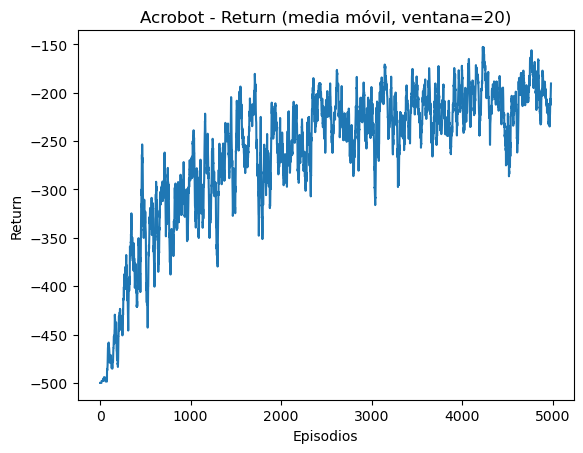

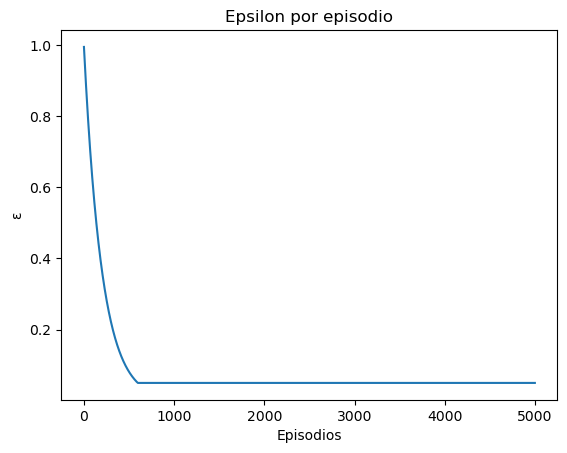

In [10]:
def moving_avg(x, k=20):
    x = np.asarray(x, dtype=float)
    if len(x) < k:
        return x
    return np.convolve(x, np.ones(k)/k, mode='valid')

# (5) Gráfico: retorno por episodio (media móvil)
ma = moving_avg(returns, k=20)

plt.figure()
plt.plot(ma)
plt.title("Acrobot - Return (media móvil, ventana=20)")
plt.xlabel("Episodios")
plt.ylabel("Return")
plt.show()

# (opcional) también puedes graficar epsilon
plt.figure()
plt.plot(eps_hist)
plt.title("Epsilon por episodio")
plt.xlabel("Episodios")
plt.ylabel("ε")
plt.show()

In [11]:

# (6) Guardar la tabla Q para reutilizar
np.save("Q_acrobot.npy", Q)
print("Q guardada como Q_acrobot.npy")


Q guardada como Q_acrobot.npy


## Grabacion

In [12]:

# (7) Evaluación final y (opcional) grabación de video
if VIDEO_EVAL:
    avgR, stdR = evaluate_greedy(Q, episodios=1, seed=SEED+999, record_video=True)
    print(f"Return del episodio grabado: {avgR:.2f}")
    print(f"Video guardado en ./{VIDEO_FOLDER}")
else:
    avgR, stdR = evaluate_greedy(Q, episodios=5, seed=SEED+200, record_video=False)
    print(f"Evaluación (5 eps, greedy): media {avgR:.2f} ± {stdR:.2f}")
    print("Para grabar video: establece VIDEO_EVAL=True y re-ejecuta esta celda.")


c:\Users\LENOVO\anaconda3\envs\NewEntorno3\lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\LENOVO\OneDrive\Desktop\python\videos_acrobot folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Return del episodio grabado: -187.00
Video guardado en ./videos_acrobot
